<a href="https://colab.research.google.com/github/abdallaho98/AutoSpeech/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip3 install ktrain

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [3]:
import ktrain
from ktrain import text

In [169]:
import pandas as pd
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       df.loc[cnt] = [int(x[1]) , x[0]]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس للشركاء في مال شائع أن يطلبوا قسمته إذا تب...,0,0,0,1,0
1,إذا وقع تحريف في نص السفتجة فالأشخاص الموقعون ...,0,0,0,0,1
2,يجوز الحجز على الأجر أو المرتب بقيمة النفقة ال...,0,1,0,0,0
3,يعين القاضي طبقا لأحكام قانون الأسرة، مقدما من...,0,0,1,0,0
4,يجوز للعموم المعارضة في أي تصحيح قضائي أو إدار...,0,1,0,0,0


In [192]:
import pandas as pd
import snowballstemmer
import re
import string
ar_light_stem = snowballstemmer.stemmer('arabic') 
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       result = re.sub(r'[0-9,.()،]+', '', x[0])
       listStrin = [ar_light_stem.stemWord(text) for text in result.split(' ')]
       strin = ' '.join(listStrin)
       df.loc[cnt] = [int(x[1]) , strin]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس شركاء في مال شايع ان يطلب قسم اذا تبين من ...,0,0,0,1,0
1,اذا وقع تحريف في نص سفتج فالاشخاص موقع علي بعد...,0,0,0,0,1
2,يجوز حجز علي اجر او مرتب قيم نفق غذاء اذا كان ...,0,1,0,0,0
3,يعين قاض طبق لاحكام قانون اسر مقدم من بين اقار...,0,0,1,0,0
4,يجوز عموم معارض في اي تصحيح قضاء او ادار لعقد ...,0,1,0,0,0


In [273]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['right', 'permit','obligation' ,'prohibition' , 'other'],
                                                                   maxlen=1000, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=5)


language: ar
Word Counts: 3387
Nrows: 931
931 train sequences
train sequence lengths:
	mean : 27
	95percentile : 48
	99percentile : 59
Adding 5-gram features
max_features changed to 176342 with addition of ngrams
Average train sequence length with ngrams: 123
train (w/ngrams) sequence lengths:
	mean : 124
	95percentile : 230
	99percentile : 287
x_train shape: (931,1000)
y_train shape: (931, 5)
Is Multi-Label? False
104 test sequences
test sequence lengths:
	mean : 24
	95percentile : 44
	99percentile : 53
Average test sequence length with ngrams: 43
test (w/ngrams) sequence lengths:
	mean : 43
	95percentile : 94
	99percentile : 110
x_test shape: (104,1000)
y_test shape: (104, 5)


In [303]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer=tokenize)
tf_train = vect.fit_transform(x_train)
tf_test = vect.transform(x_test)
model = text.text_classifier('nbsvm', (tf_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(tf_train, y_train), 
                             val_data=(tf_test, y_test), 
                             batch_size=8)

AttributeError: ignored

simulating training for different learning rates... this may take a few moments...
Train on 931 samples
Epoch 1/1024
931/931 [==============================] - 1s 949us/sample - loss: 1.6042 - accuracy: 0.3802
Epoch 2/1024
931/931 [==============================] - 1s 621us/sample - loss: 1.6037 - accuracy: 0.3835
Epoch 3/1024
931/931 [==============================] - 1s 641us/sample - loss: 1.6023 - accuracy: 0.3888
Epoch 4/1024
931/931 [==============================] - 1s 626us/sample - loss: 1.5975 - accuracy: 0.4307
Epoch 5/1024
931/931 [==============================] - 1s 619us/sample - loss: 1.5822 - accuracy: 0.5596
Epoch 6/1024
931/931 [==============================] - 1s 598us/sample - loss: 1.5344 - accuracy: 0.8034
Epoch 7/1024
931/931 [==============================] - 1s 610us/sample - loss: 1.3941 - accuracy: 0.9431
Epoch 8/1024
931/931 [==============================] - 1s 632us/sample - loss: 1.0613 - accuracy: 0.9753
Epoch 9/1024
931/931 [==========================

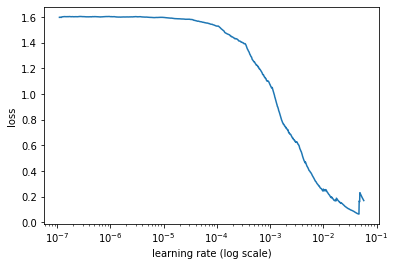

In [291]:
learner.lr_find(show_plot=True)

In [293]:
learner.autofit(2e-3, 1)



begin training using triangular learning rate policy with max lr of 0.002...
Train on 931 samples, validate on 104 samples
931/931 [==============================] - 1s 660us/sample - loss: 0.3098 - accuracy: 0.9764 - val_loss: 0.9299 - val_accuracy: 0.7692


In [294]:
learner.view_top_losses(n=3, preproc=preproc)

----------
id:98 | loss:3.71 | true:obligation | pred:prohibition)

معدل لا يجوز جمع عام مهم كان اغلب اصو ان تلزم احد شركاء في ملك تغيير اجزاء خاص فيم اعد له او تغيير كيف انتفاع بها كما هو مقرر في نظام ملك مشترك
----------
id:37 | loss:2.68 | true:right | pred:permit)

يدفع اجر متعامل متعاقد وفق كيف الات سعر اجمال ناء علي قايم سعر وحد ناء علي نفق مراقب سعر يمك مصلح متعاقد مراعا اسعار تفضيل دفع صفق وفق صيغ سعر اجمال
----------
id:19 | loss:2.12 | true:other | pred:prohibition)

يوصف اي جهاز من اجهز اقفال او شروع في ذلك سواء او اتلاف او بء طريق اخري حيث يسمح لء شخص دخول الي مكان او علي اي شيء يوجد في مكان او في او


In [295]:
p = ktrain.get_predictor(learner.model, preproc)

In [296]:
p.predict("لا يجوز أن يكون تأويل العبارات الغامضة في عقود الاذعان ضارا بمصلحة الطرف المذعن")

'prohibition'

In [297]:
p.predict("يمنع إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'prohibition'

In [298]:
p.predict("يجوز أن يؤمر بالنفاذ المعجل بالنسبة لهذا الإجرا")

'permit'

In [299]:
p.predict("يجوز تخفيض العقوبة المنصوص عليها قانونا بالنسبة للشخص الطبيعي الذي قضي بإدانته وتقررت إفادته بظروف مخففة")

'permit'